In [550]:
from nsepython import *
import pandas as pd
import numpy as np
import datetime
import math
import requests
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [168]:
response = requests.get('https://api.upstox.com/historical/v2/NSE_FO/49768/1', headers=headers, params=params1)

In [562]:
#global variables################
#cache = {}
column_values = ['timestamp', 'open', 'high', 'low', 'close','temp']
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0',
    'Accept': 'application/json',
    'Accept-Language': 'en-US,en;q=0.5',
    'access_token': 'ls-2MBy1pTEPSDBRpmPJ3DsrklYFZnE0cuAf5c7rc4I9XeHRwUWPJB5zYdvmSIoxtjx',
    'Origin': 'https://pro.upstox.com',
    'Connection': 'keep-alive',
    'Referer': 'https://pro.upstox.com/',
    'TE': 'Trailers',
}
params = (
    ('start_timestamp', '1623777518000'),
    ('end_timestamp', '1624263419000'),
)

timings = [[9,20], [15,0]]
friday = datetime.datetime(2021, 6, 18)
monday = datetime.date(2021,6,21)
tuesday = datetime.date(2021,6,22)
wednesday = datetime.date(2021,6,23)
thursday = datetime.date(2021,6,24)

scripts = {'BANKNIFTY':'NIFTY BANK', 'NIFTY':'NIFTY 50',
           'BANKNIFTY_35200PE':'49884','BANKNIFTY_35200CE':'49883',
           'BANKNIFTY_35100PE':'49882','BANKNIFTY_35100CE':'49881',
           'BANKNIFTY_35000CE':'55352','BANKNIFTY_35000PE':'55353',
           'BANKNIFTY_34600CE':'49764','BANKNIFTY_34600PE':'49765',
           'BANKNIFTY_34500CE':'38443','BANKNIFTY_34500PE':'38450',
           'BANKNIFTY_34700CE':'49766','BANKNIFTY_34700PE':'49767',
           'BANKNIFTY_34100CE':'49664','BANKNIFTY_34100PE':'49665',
           'BANKNIFTY_34200CE':'49755','BANKNIFTY_34200PE':'49759',
           'BANKNIFTY_34900CE':'49770','BANKNIFTY_34900PE':'49771',
           'BANKNIFTY_34300CE':'49760','BANKNIFTY_34300PE':'49761',
           'BANKNIFTY_34400CE':'49762','BANKNIFTY_34400PE':'49763',
           'BANKNIFTY_34800CE':'49768','BANKNIFTY_34800PE':'49769',
           'BANKNIFTY_35300CE':'49885','BANKNIFTY_35300PE':'49886',
           'BANKNIFTY_35400CE':'49887','BANKNIFTY_35400PE':'49888',
           'BANKNIFTY_35500CE':'49889','BANKNIFTY_35500PE':'49890',
           'BANKNIFTY_35600CE':'50051','BANKNIFTY_35600PE':'50087',
           'BANKNIFTY_35700CE':'50088','BANKNIFTY_35700PE':'50089',
           'BANKNIFTY_35800CE':'50090','BANKNIFTY_35800PE':'50091',
           'BANKNIFTY_35900CE':'50092','BANKNIFTY_35900PE':'50093',
           'BANKNIFTY_36000CE':'43177','BANKNIFTY_36000PE':'43181'
          }
#43177,43181

In [390]:
def read_data(url, headers, params):
    print(f"url:{url}")
    response = requests.get(url, headers=headers, params=params)
    print(f'req status: {response.status_code}')
    raw_data = response.json()['data']
    print(f"total count:{len(raw_data)}")
    assert (len(raw_data) > 0),"no values returned, check params"
    raw_data = [[float(x1) for x1 in x.split(",")] for x in raw_data]
    df = pd.DataFrame(data = np.array(raw_data), 
                  columns = column_values)
    df = df.drop(labels=['temp'],axis=1)
    df['timestamp']=pd.to_numeric(df['timestamp']/1000,downcast='integer')
    return df.set_index('timestamp')

def get_index_prices(name, startdate = None, enddate = None):
    if(cache.get(name) is None):
        url = "https://api.upstox.com/historical/v2/NSE_INDEX/{}/1".format(scripts[name])
        params1 = getparams(startdate, enddate)
        df = read_data(url, headers, params1)
        cache[name] = df
    else:
        print(f'getting data for:{name} from cache')
    return cache[name]

def getparams(startdate, enddate):
    if(startdate is None):
        startdate=friday
    if(enddate is None):
        enddate=thursday
    params1 = (    
            ('start_timestamp', index_from_date(add_date_time(startdate, 9, 15))*1000),
            ('end_timestamp', index_from_date(add_date_time(enddate, 15, 30))*1000)
        )
    return params1

def get_fno_prices(name, startdate = None, enddate = None):
    if(cache.get(name) is None):
        url = "https://api.upstox.com/historical/v2/NSE_FO/{}/1".format(scripts[name])
        params1 = getparams(startdate, enddate)
        df = read_data(url, headers, params1)
        cache[name] = df
    else:
        print(f'getting data for:{name} from cache')
    return cache[name]

def refresh_cache():
    cache = {}
    
def get_ATMVal_bnf(price):
    return math.ceil(price/100.0) * 100

def add_date_time(date, hours, minutes):
    return datetime.datetime.combine(date,datetime.time(hours,minutes))
    
def index_from_date(date):
    return int((date - datetime.datetime(1970, 1, 1)).total_seconds() - 5.5 * 60 * 60)

In [352]:
class Order:
    
    def __init__(self, script, ordertype, buy_val, sell_val, quantity):
        self.script = script
        assert (ordertype == 'buy' or ordertype == 'sell'), "order should be buy or sell"
        self.ordertype = ordertype
        self.buy_val = buy_val
        self.sell_val = sell_val
        self.pnl = 0.0
        self.quantity = quantity
    
    def pnl(self):
        if(self.ordertype == 'buy'):
            return (self.sell_val - self.buy_val) * quantity
        else:
            return (self.sell_val - self.buy_val) * quantity
    
    def toStr(self):
        print(f'script:{self.script}, ordertype:{self.ordertype}, buy:{self.buy_val}, sell:{self.sell_val}, quantity:{self.quantity}')
        

class OrderBook:
    
    def __init__(self):
        self.orders = []
    
    def get_orders(self):
        return self.orders
        
    def neworder(self, order):
        self.orders.append(order)
        
    def addorders(self, orders):
        for o in orders:
            self.neworder(o)
        
    def pnl(self):
        pnl = 0
        for o in self.orders:
            if(o.ordertype == 'buy'):
                pnl -= o.buy_val * o.quantity
            else:
                pnl += o.sell_val * o.quantity
        return pnl
    
    def printorders(self):
        for o in self.orders:
            o.toStr()

In [250]:
book = OrderBook()

#buy at morning
book.neworder(Order(scrip1, 'sell', 0, scrip1_price.loc[index_from_date(buydate)]['open'], 25))
book.neworder(Order(scrip2, 'sell', 0, scrip2_price.loc[index_from_date(buydate)]['open'], 25))

#sell at evening
book.neworder(Order(scrip1, 'buy', scrip1_price.loc[index_from_date(selldate)]['open'],0, 25))
book.neworder(Order(scrip2, 'buy', scrip2_price.loc[index_from_date(selldate)]['open'],0, 25))

book.pnl()


2056.25

In [327]:
#long straddle
def longstraddle(day, step = 0, orderbook = None):
    
    start = add_date_time(day, timings[0][0], timings[0][1])
    end = add_date_time(day, timings[1][0], timings[1][1])

    bnf_prices = get_index_prices('BANKNIFTY')

    close = bnf_prices.loc[index_from_date(start)]['close']

    atm_val = get_ATMVal_bnf(close)

    scrip1 = 'BANKNIFTY_'+str(atm_val)+'CE'
    scrip2 = 'BANKNIFTY_'+str(atm_val)+'PE'
    print(f'buying strikes: {scrip1}, {scrip2}')
    
    scrip1_price = get_fno_prices(scrip1)
    scrip2_price = get_fno_prices(scrip2)

    buydate = add_date_time(day, 9, 20)
    selldate = add_date_time(day, 15, 0)
    
    
    book = OrderBook()
    
    #buy at morning
    book.neworder(Order(scrip1, 'buy', scrip1_price.loc[index_from_date(buydate)]['open'], 0, 25))
    book.neworder(Order(scrip2, 'buy', scrip2_price.loc[index_from_date(buydate)]['open'], 0, 25))

    #sell at evening
    book.neworder(Order(scrip1, 'sell', 0, scrip1_price.loc[index_from_date(selldate)]['close'], 25))
    book.neworder(Order(scrip2, 'sell', 0, scrip2_price.loc[index_from_date(selldate)]['close'], 25))

    print(f"pnl for the day {book.pnl()}")
    
    if(orderbook is not None):
        orderbook.addorders(book.get_orders())
    else:
        orderbook = book
    
    print(f"overall pnl {orderbook.pnl()}")
    
    return book


In [341]:
#short straddle
def shortstraddle(day, step = 0, orderbook = None):
    
    start = add_date_time(day, timings[0][0], timings[0][1])
    end = add_date_time(day, timings[1][0], timings[1][1])

    bnf_prices = get_index_prices('BANKNIFTY')

    close = bnf_prices.loc[index_from_date(start)]['close']

    atm_val = get_ATMVal_bnf(close)

    scrip1 = 'BANKNIFTY_'+str(atm_val)+'CE'
    scrip2 = 'BANKNIFTY_'+str(atm_val)+'PE'
    print(f'buying strikes: {scrip1}, {scrip2}')
    
    scrip1_price = get_fno_prices(scrip1)
    scrip2_price = get_fno_prices(scrip2)

    buydate = add_date_time(day, 9, 20)
    selldate = add_date_time(day, 15, 0)
    
    
    book = OrderBook()
    
    #buy at morning
    book.neworder(Order(scrip1, 'sell', 0, scrip1_price.loc[index_from_date(buydate)]['open'], 25))
    book.neworder(Order(scrip2, 'sell', 0, scrip2_price.loc[index_from_date(buydate)]['open'], 25))

    #sell at evening
    book.neworder(Order(scrip1, 'buy', scrip1_price.loc[index_from_date(selldate)]['close'], 0, 25))
    book.neworder(Order(scrip2, 'buy', scrip2_price.loc[index_from_date(selldate)]['close'], 0, 25))

    print(f"pnl for the day {book.pnl()}")
    
    if(orderbook is not None):
        orderbook.addorders(book.get_orders())
    else:
        orderbook = book
    
    print(f"overall pnl {orderbook.pnl()}")
    
    return book

In [324]:
orderbook = OrderBook()
pnls = []
fribook=longstraddle(friday, orderbook=orderbook)
pnls.append(fribook.pnl())
monbook = longstraddle(monday,orderbook=orderbook)
pnls.append(monbook.pnl())
tuesbook = longstraddle(tuesday,orderbook=orderbook)
pnls.append(tuesbook.pnl())
wedbook = longstraddle(wednesday,orderbook=orderbook)
pnls.append(wedbook.pnl())

getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_34600CE, BANKNIFTY_34600PE
getting data for:BANKNIFTY_34600CE from cache
getting data for:BANKNIFTY_34600PE from cache
pnl for the day -2046.25
overall pnl -2046.25


In [342]:
orderbook = OrderBook()
pnls1 = []
fribook=shortstraddle(friday, orderbook=orderbook)
pnls1.append(fribook.pnl())
monbook = shortstraddle(monday,orderbook=orderbook)
pnls1.append(monbook.pnl())
tuesbook = shortstraddle(tuesday,orderbook=orderbook)
pnls1.append(tuesbook.pnl())
wedbook = shortstraddle(wednesday,orderbook=orderbook)
pnls1.append(wedbook.pnl())

getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_34600CE, BANKNIFTY_34600PE
getting data for:BANKNIFTY_34600CE from cache
getting data for:BANKNIFTY_34600PE from cache
pnl for the day 2046.25
overall pnl 2046.25
getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_34100CE, BANKNIFTY_34100PE
getting data for:BANKNIFTY_34100CE from cache
getting data for:BANKNIFTY_34100PE from cache
pnl for the day -3877.5
overall pnl -1831.25
getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_35200CE, BANKNIFTY_35200PE
getting data for:BANKNIFTY_35200CE from cache
getting data for:BANKNIFTY_35200PE from cache
pnl for the day -492.5
overall pnl -2323.75
getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_34900CE, BANKNIFTY_34900PE
getting data for:BANKNIFTY_34900CE from cache
getting data for:BANKNIFTY_34900PE from cache
pnl for the day 283.75
overall pnl -2040.0


In [328]:
tuesbook = longstraddle(tuesday,orderbook=orderbook)
pnls.append(tuesbook.pnl())

getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_35200CE, BANKNIFTY_35200PE
url:https://api.upstox.com/historical/v2/NSE_FO/49883/1
req status: 200
total count:1501
url:https://api.upstox.com/historical/v2/NSE_FO/49884/1
req status: 200
total count:1501
pnl for the day 492.5
overall pnl 2323.75


In [330]:
wedbook = longstraddle(wednesday,orderbook=orderbook)
pnls.append(wedbook.pnl())

getting data for:BANKNIFTY from cache
buying strikes: BANKNIFTY_34900CE, BANKNIFTY_34900PE
getting data for:BANKNIFTY_34900CE from cache
getting data for:BANKNIFTY_34900PE from cache
pnl for the day -283.75
overall pnl 1756.25


In [336]:
pnls

[-2046.25, 3877.5, 492.5, -283.75]

In [149]:
#df['Date'] = pd.Series( [datetime.datetime.fromtimestamp(x) for x in df['timestamp']])
df['Date'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))


In [262]:
#df2=get_index_prices('BANKNIFTY')
close = bnf_prices.loc[index_from_date(add_date_time(friday, timings[0][0], timings[0][1]))]['close']
print(get_ATMVal_bnf(close))

close = bnf_prices.loc[index_from_date(add_date_time(monday, timings[0][0], timings[0][1]))]['close']
print(get_ATMVal_bnf(close))

close = bnf_prices.loc[index_from_date(add_date_time(tuesday, timings[0][0], timings[0][1]))]['close']
print(get_ATMVal_bnf(close))

close = bnf_prices.loc[index_from_date(add_date_time(wednesday, timings[0][0], timings[0][1]))]['close']
print(get_ATMVal_bnf(close))


34600
34100
35200
34900


KeyError: 'BANKNIFTY_34600PE1'

In [407]:
days = []
for i in range(1,23):
    d=datetime.datetime(2021,6,i)
    if(d.isoweekday() <= 5):
        days.append(d)

In [408]:
days

[datetime.datetime(2021, 6, 1, 0, 0),
 datetime.datetime(2021, 6, 2, 0, 0),
 datetime.datetime(2021, 6, 3, 0, 0),
 datetime.datetime(2021, 6, 4, 0, 0),
 datetime.datetime(2021, 6, 7, 0, 0),
 datetime.datetime(2021, 6, 8, 0, 0),
 datetime.datetime(2021, 6, 9, 0, 0),
 datetime.datetime(2021, 6, 10, 0, 0),
 datetime.datetime(2021, 6, 11, 0, 0),
 datetime.datetime(2021, 6, 14, 0, 0),
 datetime.datetime(2021, 6, 15, 0, 0),
 datetime.datetime(2021, 6, 16, 0, 0),
 datetime.datetime(2021, 6, 17, 0, 0),
 datetime.datetime(2021, 6, 18, 0, 0),
 datetime.datetime(2021, 6, 21, 0, 0),
 datetime.datetime(2021, 6, 22, 0, 0)]

In [564]:
#strategy 1

def safe_get_val(arr,i,d):
    try:
        return arr[i].loc[d]
    except:
        try:
            return arr[i].loc[d+60]
        except:
            return arr[i].loc[d-60]
ops = {}
prevd = days[0]
res = np.ndarray([len(days)-1,5])
res.fill(0)
i,j=0,0

for d in days[1:]:
    d1 = index_from_date(add_date_time(d, 9, 16))
    d2 = index_from_date(add_date_time(prevd, 15, 29))
    prevd = d
    #print(f'close:{d2}')
    indexlast = index['BANKNIFTY'].loc[d2]['close']
    #print(f'open:{d1}')
    indexnow = index['BANKNIFTY'].loc[d1]['open']
    res[i][1] = indexnow - indexlast
    res[i][0] = indexnow
    j=2
    atm = get_ATMVal_bnf(indexlast)
    #print(f'atm val:{atm}')
    optionlast = safe_get_val(fnos, 'BANKNIFTY_'+str(atm+100)+'CE', d2)['close']
    optionnow = safe_get_val(fnos, 'BANKNIFTY_'+str(atm+100)+'CE', d1)['open']
    
    optionlast1 = safe_get_val(fnos, 'BANKNIFTY_'+str(atm-100)+'PE', d2)['close']
    optionnow1 = safe_get_val(fnos, 'BANKNIFTY_'+str(atm-100)+'PE', d1)['open']
    
    res[i][2] = optionnow - optionlast
    res[i][3] = optionnow1 - optionlast1
    res[i][4] = res[i][2]+res[i][3]
    i += 1
    
result11 = pd.DataFrame(data = res, columns = ['spot','spotdiff','CE', 'PE', 'total'])
result11.set_index('spotdiff').sort_index(axis=0).head()

,spot,CE,PE,total
spotdiff,,,,
-652.25,34040.00,-182.30,414.45,232.15
-287.40,34699.35,-155.75,128.95,-26.80
-207.90,34847.50,-111.65,91.20,-20.45
-147.35,35186.40,-102.35,93.95,-8.40
-101.75,35123.80,-44.00,46.70,2.70


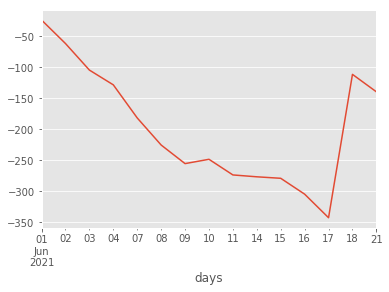

In [554]:
result1 = result.set_index('spotdiff')
#spotdf = result['spot']
#result = result.drop('spot',axis=1)
result['days'] = pd.Series(days[:-1])
result2 = result.set_index('days')
result2['total'].cumsum().plot()

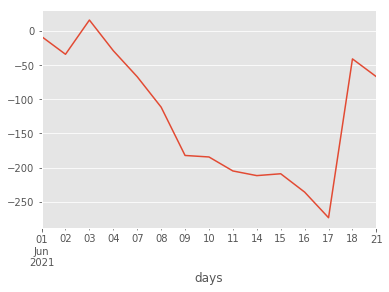

In [565]:
result11['days'] = pd.Series(days[:-1])
result21 = result11.set_index('days')
result21['total'].cumsum().plot()

In [566]:
result21['total'].sum()

-67.149999999999949

In [456]:
#sell side
ops = {}
prevd = days[0]
res = np.ndarray([len(days), len(scripts)])
res.fill(0)
i,j=0,0

for d in days[1:]:
    d1 = index_from_date(add_date_time(d, 9, 16))
    d2 = index_from_date(add_date_time(prevd, 15, 29))
    prevd = d
    print(f'close:{d2}')
    indexlast = index['BANKNIFTY'].loc[d2]['close']
    print(f'open:{d1}')
    indexnow = index['BANKNIFTY'].loc[d1]['open']
    res[i][1] = indexnow - indexlast
    res[i][0] = indexnow
    j=2
    for f in fnos.keys():
        last = fnos[f].loc[d2]['close']
        now = fnos[f].loc[d1]['open']
        diff = now - last
        f1 = f.replace('PE','').replace('CE','')
        ops[f] = diff
        res[i][j] = diff
        j += 1
        #print(f"spot:{index['BANKNIFTY'].loc[d1]['open']}, index Diff:{indexnow - indexlast}, {f} diff:{diff}")
    i += 1

cols = [x for x in fnos.keys()]
cols.insert(0,'spotdiff')
cols.insert(0,'spot')

result = pd.DataFrame(data = res, 
                  columns = cols)

close:1622541540
open:1622605560
close:1622627940
open:1622691960
close:1622714340
open:1622778360
close:1622800740
open:1623037560
close:1623059940
open:1623123960
close:1623146340
open:1623210360
close:1623232740
open:1623296760
close:1623319140
open:1623383160
close:1623405540
open:1623642360
close:1623664740
open:1623728760
close:1623751140
open:1623815160
close:1623837540
open:1623901560
close:1623923940
open:1623987960
close:1624010340
open:1624247160
close:1624269540
open:1624333560


In [459]:
result.set_index('spotdiff').sort_index(axis=0).head()

,spot,BANKNIFTY_35200PE,BANKNIFTY_35200CE,BANKNIFTY_35100PE,BANKNIFTY_35100CE,BANKNIFTY_35000CE,BANKNIFTY_35000PE,BANKNIFTY_34600CE,BANKNIFTY_34600PE,BANKNIFTY_34500CE,...,BANKNIFTY_34700CE,BANKNIFTY_34700PE,BANKNIFTY_34100CE,BANKNIFTY_34100PE,BANKNIFTY_34200CE,BANKNIFTY_34200PE,BANKNIFTY_34900CE,BANKNIFTY_34900PE,BANKNIFTY_34300CE,BANKNIFTY_34300PE
spotdiff,,,,,,,,,,,,,,,,,,,,,
-652.25,34040.00,568.35,-88.65,532.60,-109.90,-133.60,513.85,-221.35,414.45,-259.05,...,-209.25,440.15,-361.35,284.35,-327.15,320.80,-148.50,499.65,-306.0,339.25
-287.40,34699.35,164.75,-144.25,151.95,-155.75,-166.65,141.10,-224.70,101.20,-224.10,...,-197.00,111.50,-252.15,70.40,-239.10,64.55,-176.05,128.95,-249.4,71.10
-207.90,34847.50,96.90,-111.65,94.60,-119.80,-126.75,91.20,-138.20,67.20,-154.10,...,-145.55,68.55,-244.15,43.15,0.00,41.95,-125.65,85.55,0.0,47.85
-147.35,35186.40,89.05,-108.90,71.85,-144.75,-118.00,67.95,0.00,69.65,-127.65,...,-203.20,53.75,0.00,0.00,0.00,5.30,0.00,92.70,0.0,14.95
-101.75,35123.80,46.70,-50.90,43.20,-55.30,-59.75,40.00,0.00,25.65,-79.85,...,-64.80,29.05,0.00,8.60,0.00,15.10,-75.45,34.00,0.0,27.75


In [526]:
result['total'].cumsum()

spotdiff
-652.25    230.90
-287.40    205.35
-207.90    180.15
-147.35    156.00
-101.75    153.60
-65.25     110.85
-58.95      57.55
-44.15      13.95
 38.40     -16.00
 56.55     -39.80
 111.70    -77.65
 163.85    -70.70
 166.20    -73.70
 192.35   -101.80
 203.20   -139.75
Name: total, dtype: float64

In [519]:
%matplotlib inline

result = result.sort_values('spotdiff', axis = 0).set_index('spotdiff')
spotdf = result['spot']
result = result.drop('spot',axis=1)

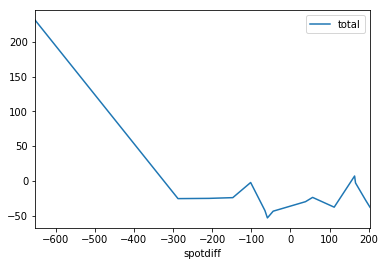

In [527]:
result[['total']].plot()

In [465]:
scripts

{'BANKNIFTY': 'NIFTY BANK',
 'BANKNIFTY_34100CE': '49664',
 'BANKNIFTY_34100PE': '49665',
 'BANKNIFTY_34200CE': '49755',
 'BANKNIFTY_34200PE': '49759',
 'BANKNIFTY_34300CE': '49760',
 'BANKNIFTY_34300PE': '49761',
 'BANKNIFTY_34500CE': '38443',
 'BANKNIFTY_34500PE': '38450',
 'BANKNIFTY_34600CE': '49764',
 'BANKNIFTY_34600PE': '49765',
 'BANKNIFTY_34700CE': '49766',
 'BANKNIFTY_34700PE': '49767',
 'BANKNIFTY_34900CE': '49770',
 'BANKNIFTY_34900PE': '49771',
 'BANKNIFTY_35000CE': '55352',
 'BANKNIFTY_35000PE': '55353',
 'BANKNIFTY_35100CE': '49881',
 'BANKNIFTY_35100PE': '49882',
 'BANKNIFTY_35200CE': '49883',
 'BANKNIFTY_35200PE': '49884',
 'NIFTY': 'NIFTY 50'}

In [563]:
fnos = {}
index = {}
for s in scripts:
    print(s)
    if(s == "BANKNIFTY" or s == "NIFTY"):
        index[s]=(get_index_prices(s, datetime.datetime(2021,6,1,9,15), datetime.datetime(2021,6,24,15,30)))
    else:
        fnos[s]=(get_fno_prices(s,datetime.datetime(2021,6,1,9,15),datetime.datetime(2021,6,24,15,30)))



BANKNIFTY
getting data for:BANKNIFTY from cache
NIFTY
getting data for:NIFTY from cache
BANKNIFTY_35200PE
getting data for:BANKNIFTY_35200PE from cache
BANKNIFTY_35200CE
getting data for:BANKNIFTY_35200CE from cache
BANKNIFTY_35100PE
getting data for:BANKNIFTY_35100PE from cache
BANKNIFTY_35100CE
getting data for:BANKNIFTY_35100CE from cache
BANKNIFTY_35000CE
getting data for:BANKNIFTY_35000CE from cache
BANKNIFTY_35000PE
getting data for:BANKNIFTY_35000PE from cache
BANKNIFTY_34600CE
getting data for:BANKNIFTY_34600CE from cache
BANKNIFTY_34600PE
getting data for:BANKNIFTY_34600PE from cache
BANKNIFTY_34500CE
getting data for:BANKNIFTY_34500CE from cache
BANKNIFTY_34500PE
getting data for:BANKNIFTY_34500PE from cache
BANKNIFTY_34700CE
getting data for:BANKNIFTY_34700CE from cache
BANKNIFTY_34700PE
getting data for:BANKNIFTY_34700PE from cache
BANKNIFTY_34100CE
getting data for:BANKNIFTY_34100CE from cache
BANKNIFTY_34100PE
getting data for:BANKNIFTY_34100PE from cache
BANKNIFTY_34200C

In [469]:
cache1 = cache

In [568]:
#write cache to file
import pickle
file = open('expired_option_data1', 'wb')

pickle.dump(cache, file)

file.close()

In [479]:
file = open('expired_option_data', 'rb')

test1 = pickle.load(file)

file.close()

In [587]:
#straddle on first 1 hr
ops = {}
prevd = days[0]
res = np.ndarray([len(days),5])
res.fill(0)
i,j=0,0

for d in days:
    d1 = index_from_date(add_date_time(d, 11, 0))
    d2 = index_from_date(add_date_time(d, 12, 30))
    #prevd = d
    #print(f'close:{d2}')
    indexlast = index['BANKNIFTY'].loc[d2]['close']
    #print(f'open:{d1}')
    indexnow = index['BANKNIFTY'].loc[d1]['open']
    res[i][1] = indexlast - indexnow
    res[i][0] = indexnow
    j=2
    atm = get_ATMVal_bnf(indexnow)
    #print(f'atm val:{atm}')
    optionlast = safe_get_val(fnos, 'BANKNIFTY_'+str(atm)+'CE', d2)['close']
    optionnow = safe_get_val(fnos, 'BANKNIFTY_'+str(atm)+'CE', d1)['open']
    
    optionlast1 = safe_get_val(fnos, 'BANKNIFTY_'+str(atm)+'PE', d2)['close']
    optionnow1 = safe_get_val(fnos, 'BANKNIFTY_'+str(atm)+'PE', d1)['open']
    
    res[i][2] = optionlast - optionnow
    res[i][3] = optionlast1 - optionnow1
    res[i][4] = res[i][2]+res[i][3]
    i += 1
    
result = pd.DataFrame(data = res, columns = ['spot','spotdiff','CE', 'PE', 'total'])
result.set_index('spotdiff').sort_index(axis=0).head()


KeyError: 'BANKNIFTY_34000CE'

In [586]:
result.set_index('spotdiff').sort_index(axis=0)

,spot,CE,PE,total
spotdiff,,,,
-389.65,34735.90,-138.20,251.20,113.00
-291.85,35344.10,-158.00,125.65,-32.35
-168.95,35569.95,-79.60,31.05,-48.55
-158.95,34847.50,-102.55,85.25,-17.30
-126.55,35309.85,-65.90,52.65,-13.25
-42.50,35186.40,-25.05,-13.50,-38.55
-28.10,34847.10,-22.55,23.95,1.40
16.40,35509.10,27.40,-9.50,17.90
54.70,35401.65,5.05,-56.30,-51.25


In [573]:
result11['total'].sum()

-67.149999999999949